GNN+RL MODEL IN UWSN

Episode 0: Total Reward = 98.7015
Episode 20: Total Reward = 98.6308
Episode 40: Total Reward = 98.7155
Episode 60: Total Reward = 98.3947
Episode 80: Total Reward = 98.6454
Episode 100: Total Reward = 98.4389
Episode 120: Total Reward = 98.6115
Episode 140: Total Reward = 98.5430
Episode 160: Total Reward = 98.2694
Episode 180: Total Reward = 98.7010
Most Reliable Path to node 99: [0, np.int64(98), 16, 64, 18, 93, 54, 96, 54, 96, np.int64(54), np.int64(24), 99]
Path Reliability: 86.71%


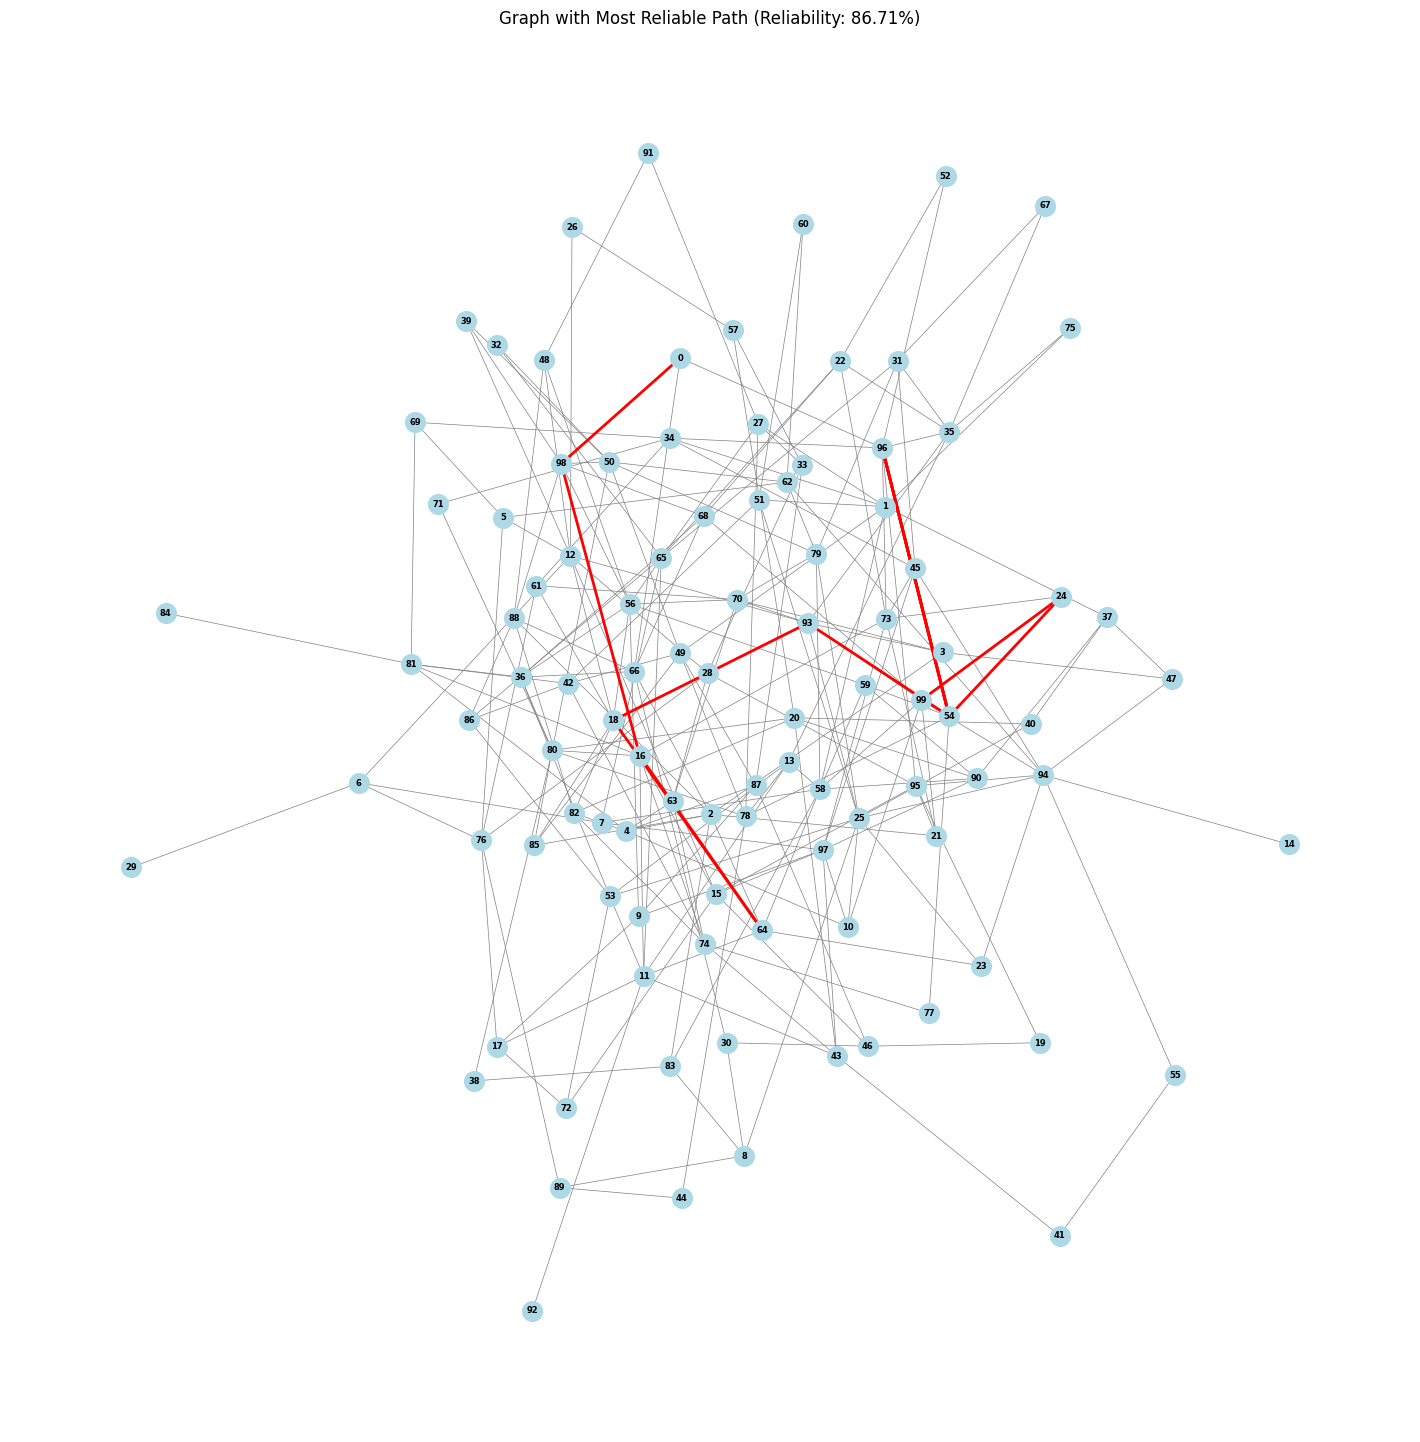

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# GNN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        h = torch.matmul(adj, x)
        return self.linear(h)

# GNN Model
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.gcn2 = GCNLayer(hidden_features, out_features)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = self.gcn2(x, adj)
        return x

# RL Agent using GNN
class GNNRLAgent:
    def __init__(self, num_nodes, hidden_dim=64):
        self.num_nodes = num_nodes
        self.model = GCN(in_features=num_nodes, hidden_features=hidden_dim, out_features=num_nodes)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        self.epsilon = 0.1
        self.gamma = 0.9

    def select_action(self, state, valid_actions, adj_matrix, node_features):
        self.model.eval()
        with torch.no_grad():
            q_values = self.model(node_features, adj_matrix)[state]
            q_values = q_values[valid_actions]
        if np.random.rand() < self.epsilon:
            return np.random.choice(valid_actions)
        else:
            return valid_actions[torch.argmax(q_values).item()]

    def train_step(self, state, action, reward, next_state, adj_matrix, node_features):
        self.model.train()

        q_values = self.model(node_features, adj_matrix)
        target_q_values = q_values.clone().detach()

        max_next_q = torch.max(q_values[next_state])
        target = reward + self.gamma * max_next_q

        target_q_values[state, action] = target

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Graph generator
def generate_graph(num_nodes):
    G = nx.erdos_renyi_graph(num_nodes, p=0.05)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(num_nodes, p=0.05)

    edge_weights = {}
    for u, v in G.edges():
        weight = np.random.uniform(0.005, 0.02)
        edge_weights[(u, v)] = weight
        edge_weights[(v, u)] = weight
    return G, edge_weights

# Path reliability
def compute_path_reliability(path, edge_weights):
    if len(path) < 2:
        return 0.0
    reliability = 1.0
    for u, v in zip(path[:-1], path[1:]):
        reliability *= (1 - edge_weights.get((u, v), 1))
    return reliability * 100

# Find path
def find_reliable_path(agent, start, target, adj_list, adj_matrix, node_features, max_steps=100):
    path = [start]
    state = start
    for _ in range(max_steps):
        if state == target:
            break
        valid_actions = adj_list[state]
        if not valid_actions:
            break
        action = agent.select_action(state, valid_actions, adj_matrix, node_features)
        path.append(action)
        state = action
    return path

# Training loop
def train_gnn_rl(num_nodes, target_node):
    G, edge_weights = generate_graph(num_nodes)
    adj_list = {i: list(G.neighbors(i)) for i in range(num_nodes)}
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)

    node_features = torch.eye(num_nodes)  # one-hot encoding for each node

    agent = GNNRLAgent(num_nodes)

    for episode in range(200):
        state = random.randint(0, num_nodes-1)
        total_reward = 0
        for step in range(100):
            valid_actions = adj_list[state]
            if not valid_actions:
                break
            action = agent.select_action(state, valid_actions, adj_matrix, node_features)
            reward = 1 - edge_weights.get((state, action), 1)
            next_state = action
            agent.train_step(state, action, reward, next_state, adj_matrix, node_features)
            state = next_state
            total_reward += reward
        if episode % 20 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward:.4f}")

    path = find_reliable_path(agent, 0, target_node, adj_list, adj_matrix, node_features)
    reliability = compute_path_reliability(path, edge_weights)
    return agent, G, edge_weights, adj_list, path, reliability

# Main Execution
num_nodes = 100
target_node = 99
agent, G, edge_weights, adj_list, path, reliability = train_gnn_rl(num_nodes, target_node)

print(f"Most Reliable Path to node {target_node}: {path}")
print(f"Path Reliability: {reliability:.2f}%")

# Plot
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=6,
    font_weight="bold",
    node_size=200,
    edge_color="gray",
    width=0.5
)
path_edges = list(zip(path[:-1], path[1:]))
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=path_edges,
    edge_color="red",
    width=2
)
plt.title(f"Graph with Most Reliable Path (Reliability: {reliability:.2f}%)", fontsize=12)
plt.show()
